In [1]:
import os
import sys
import json
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from random import randint
import matplotlib.pyplot as plt
from tqdm import tqdm
from vector_quantize_pytorch import VectorQuantize

sys.path.append(os.path.abspath('../'))
from Agent import MLPNetwork

/home/vateseifelfrej/anaconda3/envs/maddpg/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/vateseifelfrej/anaconda3/envs/maddpg/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [2]:
# training params
batch_size = 1024

alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
# number of tokens in alphabet                    
n_tokens = len(alphabet)

# dimension of goal id (RGB color of landmarks)
n_goal_id = 3

num_agents = 2
num_landmarks = 10

# I/O of speaker and listener
speaker_in = n_goal_id
speaker_out = n_tokens
listener_in = 2 + 2*num_landmarks + n_tokens + n_goal_id
listener_out = 2

n_episodes = 2000

# landamrk colors
landmarks_c = sns.color_palette(n_colors=num_landmarks)
landmarks_c = torch.tensor(landmarks_c).unsqueeze(1)

alpha=10

In [3]:
speaker = MLPNetwork(speaker_in, speaker_out)
listener = MLPNetwork(listener_in, listener_out)

# define vector quantization
vq = VectorQuantize(
    dim = 26,
    codebook_size = 26,      # codebook size
    decay = 0.8,            # the exponential moving average decay, lower means the dictionary will change faster
    threshold_ema_dead_code = 2,  # should actively replace any codes that have an exponential moving average cluster size less than 2

    #use_cosine_sim = True,   # set this to True
    #commitment_weight = 1.   # the weight on the commitment loss
)

speaker.eval()

optimizer = torch.optim.Adam(list(listener.parameters()), lr=1e-2)

In [4]:
loss_history = []
lossfun = nn.MSELoss()

for i in tqdm(range(n_episodes)):
  # relative position of landmarks wrt to listener
  landmarks_p = (torch.rand((batch_size, 2*num_landmarks)) - 0.5) * 2
  landmarks_xy = landmarks_p.reshape(batch_size, num_landmarks, 2)
  # velocity of listener
  vel = torch.rand((batch_size, 2))
  # sample target landmark indices
  ids = torch.randint(num_landmarks, (batch_size,))
  # speaker input
  goal_landmarks = (landmarks_c.repeat(batch_size, 1, 1)[ids]).squeeze(1)
  # pass through observer
  #msg = torch.softmax(speaker(goal_landmarks), 1)
  msg = speaker(goal_landmarks)
  msg, _, cmt_loss = vq(msg)
  # goal id (kinda useless to have it)
  goal_id = torch.cat(list(landmarks_c[randint(0, num_landmarks-1)] for _ in range(batch_size)), 0)
  # listener obesrvation
  obs = torch.cat((vel, landmarks_p, goal_id, msg), 1)
  # predict landmark pos
  pred = listener(obs)
  # backprop
  optimizer.zero_grad()
  target = landmarks_xy[torch.arange(batch_size), ids]
  loss = lossfun(pred, target) + alpha * cmt_loss
  loss.backward()
  optimizer.step()

  if i%100==0:
    loss_history.append(loss.item())

speaker.eval()
vq.eval()
listener.eval()


100%|██████████| 2000/2000 [00:15<00:00, 128.01it/s]


MLPNetwork(
  (net): Sequential(
    (0): Linear(in_features=51, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)

Text(0.5, 0, 'Iterations')

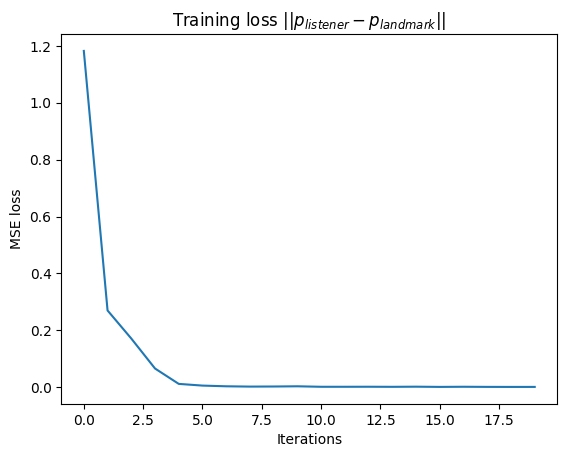

In [5]:
plt.plot(loss_history)
plt.title("Training loss $||p_{listener} - p_{landmark}||$")
plt.ylabel(f"MSE loss")
plt.xlabel("Iterations")

In [8]:
for i in range(num_landmarks):
  msg = speaker(landmarks_c[i])
  #msg_ix = torch.tensor([torch.cosine_similarity(m, feature_vectors, dim=1).argmax() for m in msg])
  #msg_ix = torch.tensor([torch.norm(feature_vectors - m.repeat(26, 1), dim=0).argmin() for m in msg])
  msg_cb, msg_ix, _ = vq(msg)
  print(torch.all(msg_cb.eq(vq.codebook[msg_ix])))
  print(alphabet[msg_ix.item()], i)

tensor(True)
A 0
tensor(True)
O 1
tensor(True)
G 2
tensor(True)
H 3
tensor(True)
C 4
tensor(True)
V 5
tensor(True)
I 6
tensor(True)
E 7
tensor(True)
B 8
tensor(True)
M 9


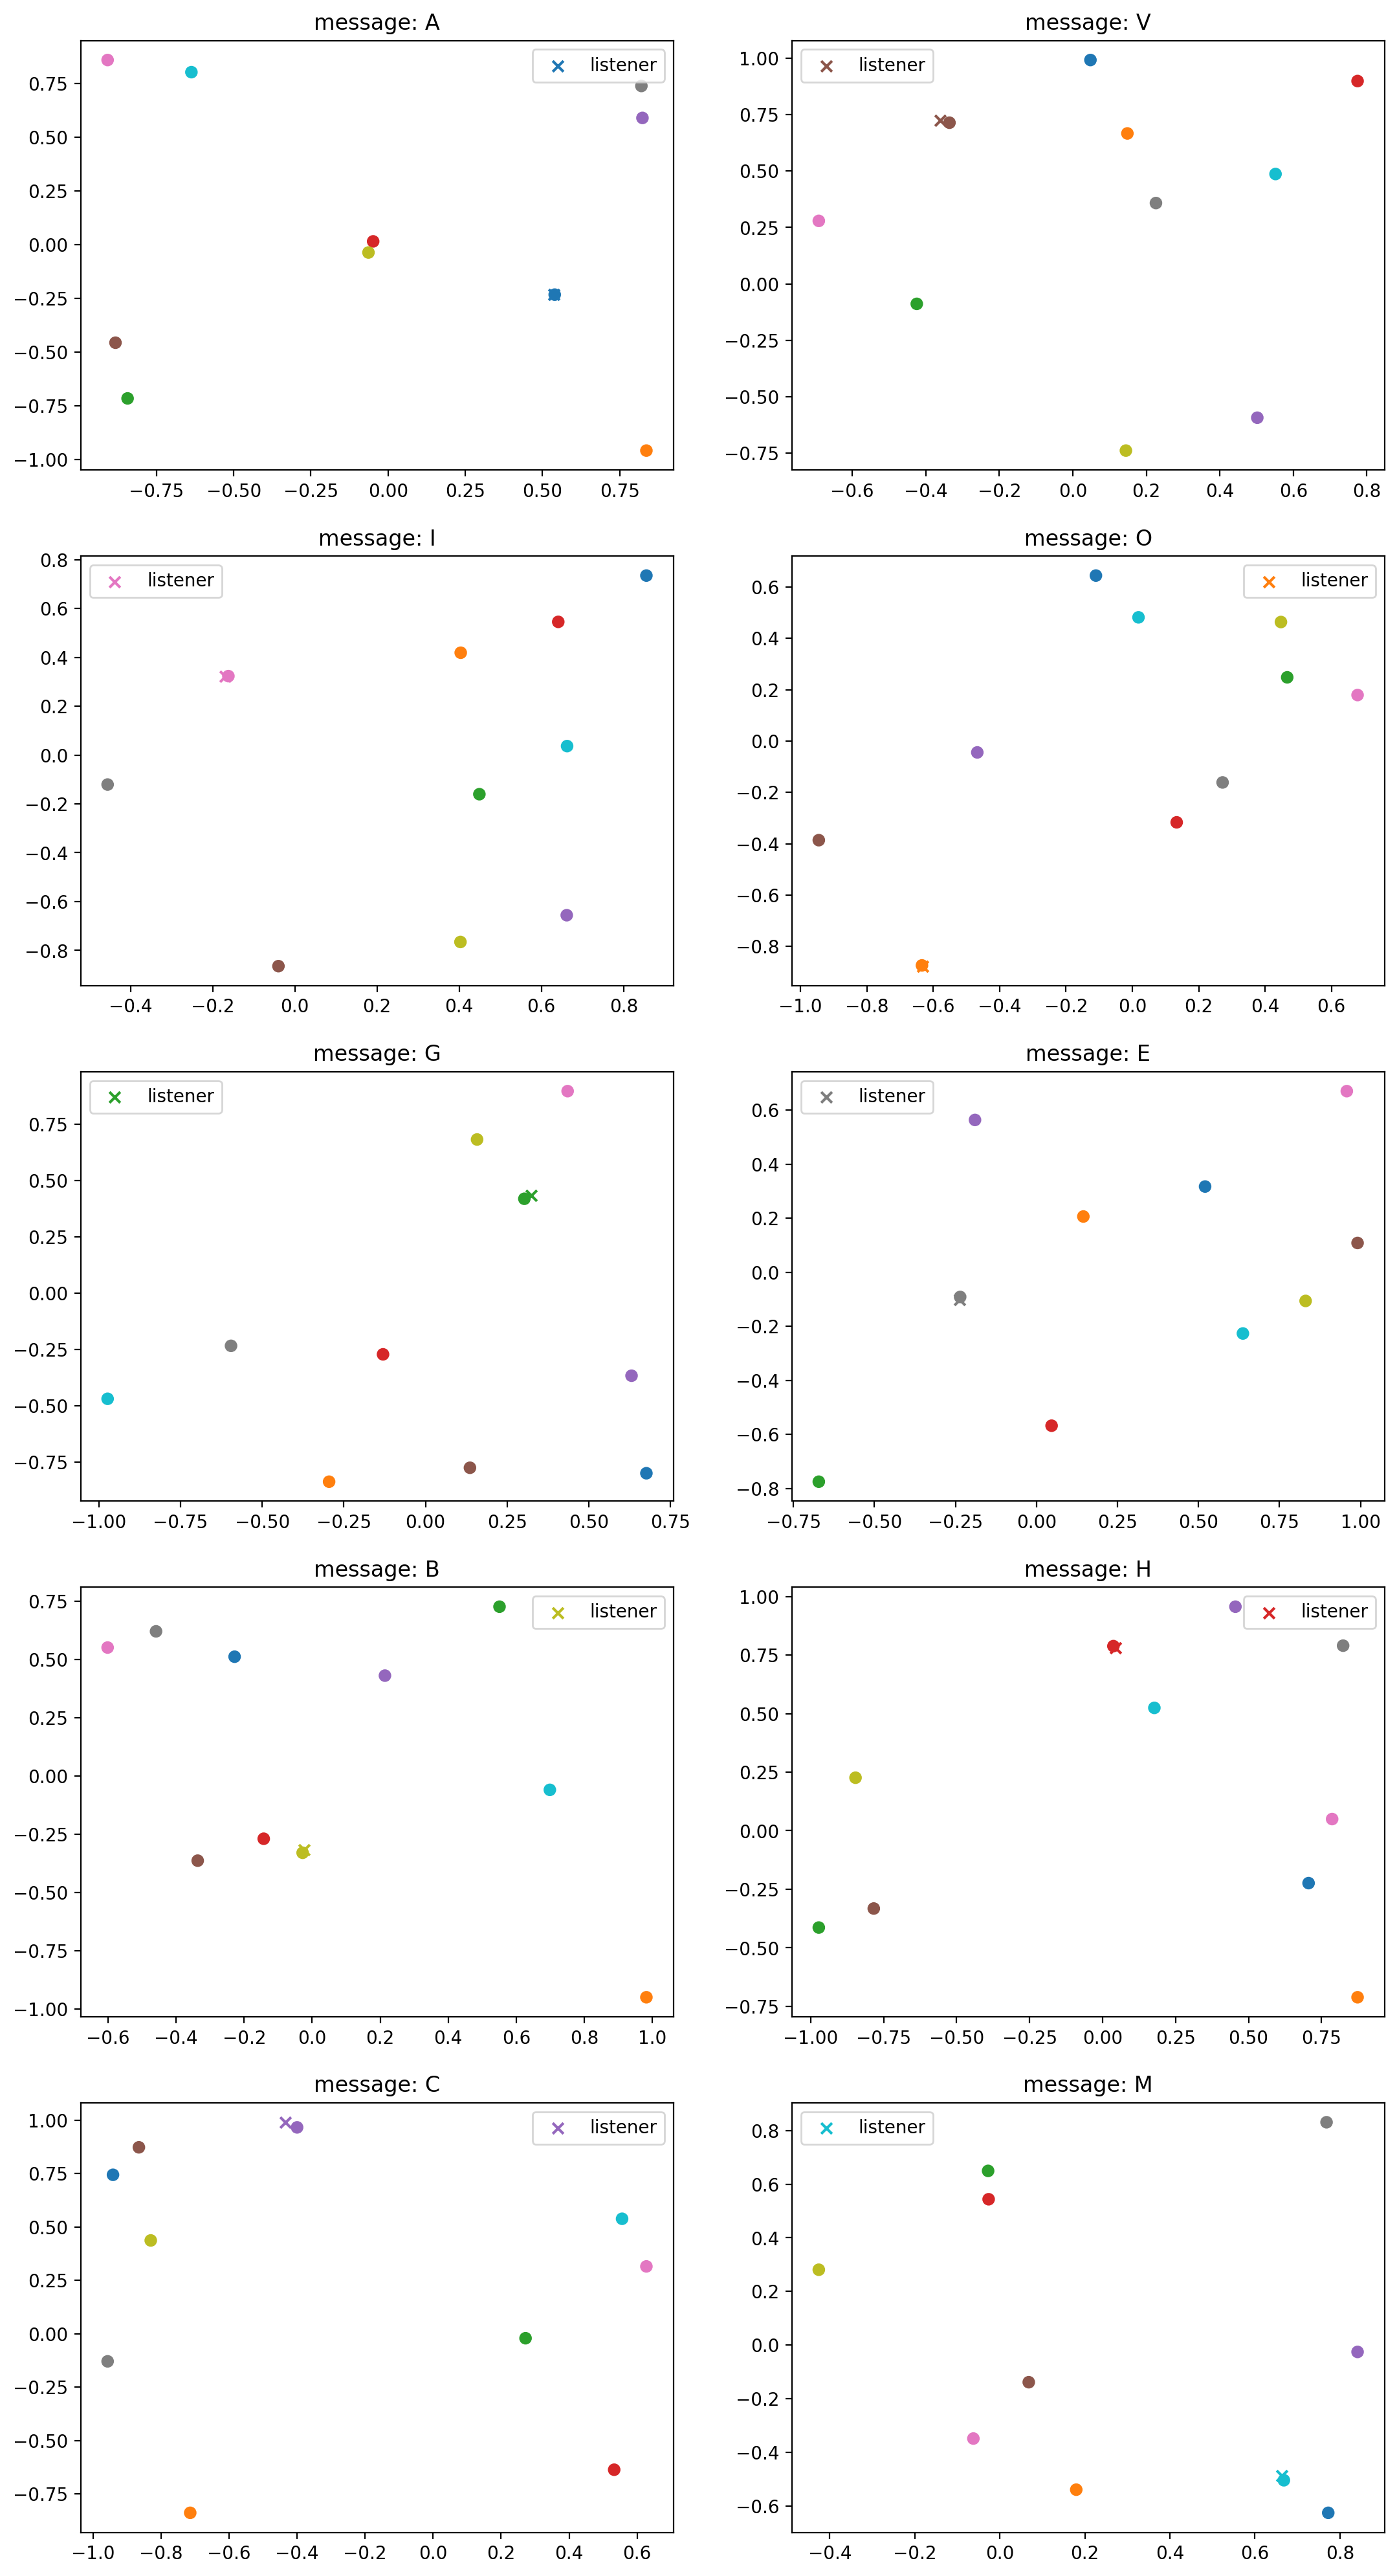

In [9]:
fig, ax = plt.subplots(nrows=int(num_landmarks/2), ncols=2, figsize=(13, 25), dpi=200)

for ix in range(num_landmarks):
  landmarks_p_eval = (torch.rand((1, 2*num_landmarks)) - 0.5) * 2
  vel = torch.rand((1, 2))
  # sample target landmark
  #ix = randint(0, num_landmarks-1)
  # pass through observer
  msg = speaker(landmarks_c[ix].repeat(1, 1))
  _, msg_ix, _ = vq(msg)
  # goal id (kinda useless to have it)
  goal_id = torch.cat(list(landmarks_c[randint(0, num_landmarks-1)] for _ in range(1)), 0)
  # listener observation
  obs = torch.cat((vel, landmarks_p_eval, landmarks_c[0], msg), 1)  
  # predict landmark pos
  action = listener(obs)
  # compute centroid of chosen message
  #centroid_xy, centroid_c = computeCentroid(msg.argmax().item())


  #plt.figure()
  ax[ix%int(num_landmarks/2)][ix%2].scatter([l for i, l in enumerate(landmarks_p_eval[0]) if i%2==0], [l for i, l in enumerate(landmarks_p_eval[0]) if i%2==1], marker='o', c=landmarks_c.squeeze())
  #ax[ix%int(num_landmarks/2)][ix%2].scatter(centroid_xy[0, 0], centroid_xy[0, 1], marker='v', c=centroid_c, label='centroid')
  ax[ix%int(num_landmarks/2)][ix%2].scatter(action[0,0].detach().numpy(), action[0,1].detach().numpy(), marker='x', c=landmarks_c[ix], label='listener')
  ax[ix%int(num_landmarks/2)][ix%2].legend(loc='best')
  ax[ix%int(num_landmarks/2)][ix%2].set_title(f"message: {alphabet[msg_ix.item()]}")

#fig.savefig('vq_speaker_listener_centroid.png')